In [1]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Load Dataset

In [2]:
dataset = pd.read_parquet(r'../local_dataset/dataset/merged_full2.parquet')

# Keep lon/lat for visualization only
lon_lat = dataset[['lon', 'lat']].copy()

# Remove lon/lat and fire from clustering
dataset.drop(columns=['lon', 'lat', 'fire'], inplace=True, errors='ignore')
print("=== Dataset Types :\n", dataset.dtypes)

dataset_numeric_columns = dataset.select_dtypes(include=['number']).columns
dataset_string_columns = dataset.select_dtypes(include=['object']).columns
dataset[dataset_numeric_columns] = dataset[dataset_numeric_columns].fillna(dataset[dataset_numeric_columns].mean())
dataset[dataset_string_columns] = dataset[dataset_string_columns].fillna(dataset[dataset_string_columns].mode().iloc[0])

print("=== Null Values :\n", dataset.isnull().sum())

X = dataset.copy()
X_numeric_columns = X.select_dtypes(include=['number']).columns
X[X_numeric_columns] = StandardScaler().fit_transform(X[X_numeric_columns])
X = pd.get_dummies(X, columns=X.select_dtypes(include=['object']).columns)

print("=== X shape:", X.shape)
print("=== X columns:", X.columns)

=== Dataset Types :
 log_precip_s1             float64
log_precip_s2             float64
log_precip_s3             float64
log_precip_s4             float64
tmax_s1                   float64
tmax_s2                   float64
tmax_s3                   float64
tmax_s4                   float64
amplitude_thermique_s1    float64
amplitude_thermique_s2    float64
amplitude_thermique_s3    float64
amplitude_thermique_s4    float64
GRIDCODE                  float64
log_area_sqm              float64
lcc_code_encoded          float64
elevation                 float32
COARSE                    float64
SAND                      float64
SILT                      float64
CLAY                      float64
TEXTURE_USDA              float64
TEXTURE_SOTER              object
BULK                      float64
REF_BULK                  float64
ORG_CARBON                float64
PH_WATER                  float64
TOTAL_N                   float64
CN_RATIO                  float64
CEC_SOIL                  f

# Finding Optimal K

Nous utilisons deux méthodes pour déterminer le nombre optimal de clusters :
1. **Elbow Method** : Cherche le "coude" dans la courbe d'inertie
2. **Silhouette Analysis** : Maximise la cohésion intra-cluster et la séparation inter-cluster

Testing K values from 2 to 50...


c:\Users\anfel\anaconda3\envs\dm\lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


K=10: Inertia=671630.53, Silhouette=0.3099
K=20: Inertia=492973.11, Silhouette=0.2534
K=30: Inertia=406224.30, Silhouette=0.2282
K=40: Inertia=360489.42, Silhouette=0.2322
K=50: Inertia=329549.24, Silhouette=0.2298

Completed!


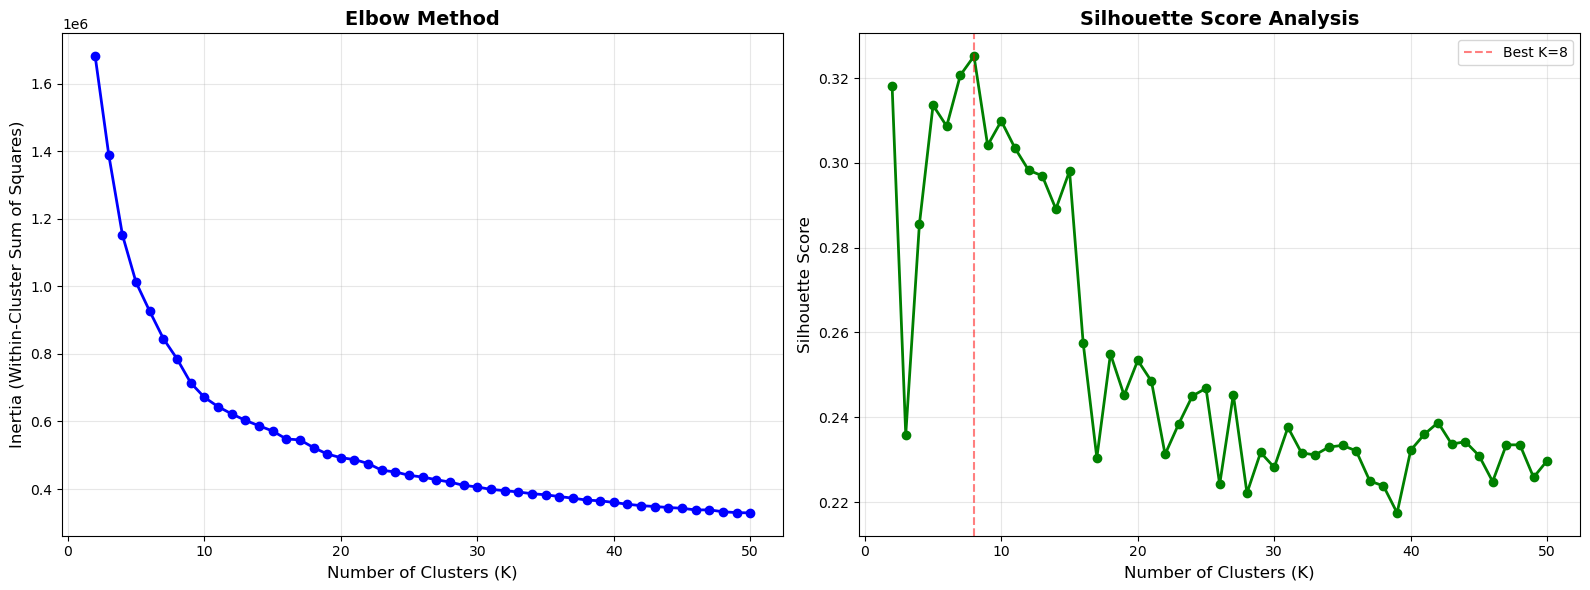


=== Recommendations ===
Best K based on Silhouette Score: 8
Silhouette Score at K=8: 0.3252

Note: Look for the 'elbow' in the left plot where the rate of decrease sharply shifts.


In [3]:
# Range of K values to test (adjust max_k as needed)
max_k = 50  # You can increase this if you think you need more clusters
k_range = range(2, max_k + 1)

# Storage for metrics
inertias = []
silhouette_scores = []

print(f"Testing K values from 2 to {max_k}...")
for k in k_range:
    # Train KMeans
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_temp = kmeans_temp.fit_predict(X)
    
    # Calculate metrics
    inertias.append(kmeans_temp.inertia_)
    silhouette_scores.append(silhouette_score(X, labels_temp))
    
    if k % 10 == 0:
        print(f"K={k}: Inertia={kmeans_temp.inertia_:.2f}, Silhouette={silhouette_scores[-1]:.4f}")

print("\nCompleted!")

# Visualize results
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Elbow Method
axes[0].plot(k_range, inertias, 'bo-', linewidth=2, markersize=6)
axes[0].set_xlabel('Number of Clusters (K)', fontsize=12)
axes[0].set_ylabel('Inertia (Within-Cluster Sum of Squares)', fontsize=12)
axes[0].set_title('Elbow Method', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Silhouette Score
axes[1].plot(k_range, silhouette_scores, 'go-', linewidth=2, markersize=6)
axes[1].set_xlabel('Number of Clusters (K)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Score Analysis', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Mark the best K based on silhouette score
best_k = k_range[np.argmax(silhouette_scores)]
axes[1].axvline(x=best_k, color='r', linestyle='--', alpha=0.5, label=f'Best K={best_k}')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\n=== Recommendations ===")
print(f"Best K based on Silhouette Score: {best_k}")
print(f"Silhouette Score at K={best_k}: {max(silhouette_scores):.4f}")
print(f"\nNote: Look for the 'elbow' in the left plot where the rate of decrease sharply shifts.")

In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Define parameter grid
param_grid = {
    'n_clusters': [8],  # Fixed to K=8 based on your analysis
    'init': ['k-means++', 'random'],
    'n_init': [10, 20, 30],
    'max_iter': [100, 300, 500],
    'algorithm': ['lloyd', 'elkan']
}

# Custom scorer using silhouette score (higher is better)
def kmeans_scorer(estimator, X):
    labels = estimator.predict(X)
    return silhouette_score(X, labels)

scorer = make_scorer(kmeans_scorer)

# Create GridSearchCV object
print("Starting Grid Search for K=8...")
grid_search = GridSearchCV(
    estimator=KMeans(random_state=42),
    param_grid=param_grid,
    scoring=scorer,
    cv=3,  # 3-fold cross-validation
    verbose=2,
    n_jobs=-1  # Use all available cores
)

# Fit Grid Search
grid_search.fit(X)

print("\n=== Grid Search Results ===")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Silhouette Score: {grid_search.best_score_:.4f}")

# Display all results sorted by score
results_df = pd.DataFrame(grid_search.cv_results_)
results_df = results_df.sort_values('rank_test_score')[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']].head(10)
print("\n=== Top 10 Configurations ===")
print(results_df.to_string(index=False))

Starting Grid Search for K=8...
Fitting 3 folds for each of 36 candidates, totalling 108 fits


c:\Users\anfel\anaconda3\envs\dm\lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(



=== Grid Search Results ===
Best Parameters: {'algorithm': 'lloyd', 'init': 'k-means++', 'max_iter': 100, 'n_clusters': 8, 'n_init': 10}
Best Silhouette Score: nan

=== Top 10 Configurations ===
                                                                                     params  mean_test_score  std_test_score  rank_test_score
{'algorithm': 'lloyd', 'init': 'k-means++', 'max_iter': 100, 'n_clusters': 8, 'n_init': 10}              NaN             NaN                1
{'algorithm': 'lloyd', 'init': 'k-means++', 'max_iter': 100, 'n_clusters': 8, 'n_init': 20}              NaN             NaN                1
{'algorithm': 'lloyd', 'init': 'k-means++', 'max_iter': 100, 'n_clusters': 8, 'n_init': 30}              NaN             NaN                1
{'algorithm': 'lloyd', 'init': 'k-means++', 'max_iter': 300, 'n_clusters': 8, 'n_init': 10}              NaN             NaN                1
{'algorithm': 'lloyd', 'init': 'k-means++', 'max_iter': 300, 'n_clusters': 8, 'n_init': 20}   


=== Best Model Evaluation ===
Silhouette Score: 0.3252
Davies-Bouldin Index: 1.2051
Calinski-Harabasz Index: 13852.9125
Inertia: 785221.68


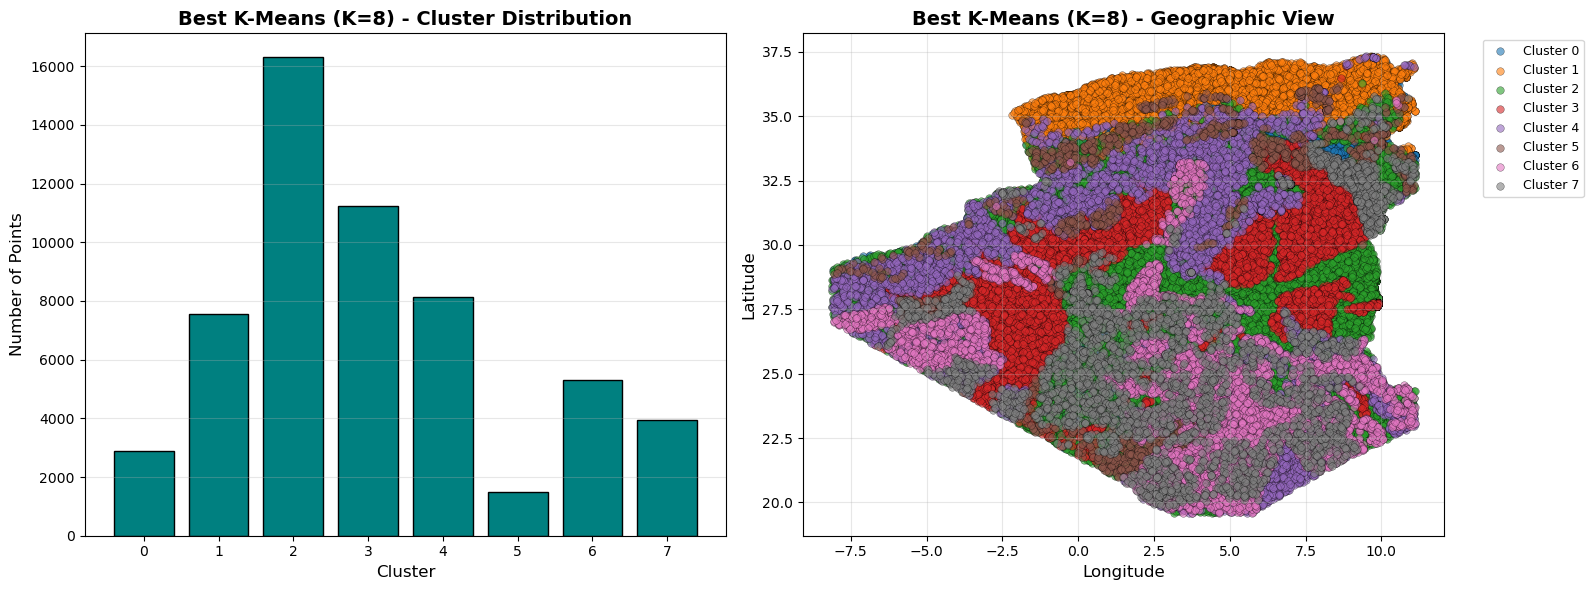

In [5]:
# Train final model with best parameters
best_kmeans = grid_search.best_estimator_
best_labels = best_kmeans.labels_

# Evaluate best model
print("\n=== Best Model Evaluation ===")
print(f"Silhouette Score: {silhouette_score(X, best_labels):.4f}")
print(f"Davies-Bouldin Index: {davies_bouldin_score(X, best_labels):.4f}")
print(f"Calinski-Harabasz Index: {calinski_harabasz_score(X, best_labels):.4f}")
print(f"Inertia: {best_kmeans.inertia_:.2f}")

# Visualize best model results
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Cluster distribution
unique_best, counts_best = np.unique(best_labels, return_counts=True)
axes[0].bar(unique_best, counts_best, color='teal', edgecolor='black')
axes[0].set_xlabel('Cluster', fontsize=12)
axes[0].set_ylabel('Number of Points', fontsize=12)
axes[0].set_title('Best K-Means (K=8) - Cluster Distribution', fontsize=14, fontweight='bold')
axes[0].set_xticks(unique_best)
axes[0].grid(axis='y', alpha=0.3)

# Geographic visualization
for cluster in unique_best:
    mask = best_labels == cluster
    axes[1].scatter(lon_lat.loc[mask, 'lon'], lon_lat.loc[mask, 'lat'], 
                   label=f'Cluster {cluster}', 
                   s=30, alpha=0.6, edgecolors='k', linewidth=0.3)

axes[1].set_xlabel('Longitude', fontsize=12)
axes[1].set_ylabel('Latitude', fontsize=12)
axes[1].set_title('Best K-Means (K=8) - Geographic View', fontsize=14, fontweight='bold')
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# SKlearn Model Training

In [ ]:
"""kmeans = KMeans(n_clusters=21, random_state=42, n_init=10)

kmeans.fit(X)

labels_sklearn = kmeans.labels_
print(f"Sklearn K-Means - Number of clusters: {kmeans.n_clusters}")
print(f"Sklearn K-Means - Inertia: {kmeans.inertia_:.2f}")"""

Sklearn K-Means - Number of clusters: 21
Sklearn K-Means - Inertia: 487244.53


# Scratch Model Training

In [9]:
import numpy as np

class FastKMeans:
    def __init__(self, n_clusters=8, max_iter=100, random_state=42):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.random_state = random_state
        self.centroids = None
        self.labels_ = None
        self.inertia_ = None
        
    def fit(self, X):
        np.random.seed(self.random_state)
        
        # Initialize centroids randomly
        random_indices = np.random.choice(X.shape[0], self.n_clusters, replace=False)
        self.centroids = X[random_indices]
        
        for iteration in range(self.max_iter):
            # Assign points to nearest centroid
            distances = self._compute_distances(X)
            new_labels = np.argmin(distances, axis=1)
            
            # Check convergence
            if iteration > 0 and np.array_equal(new_labels, self.labels_):
                break
                
            self.labels_ = new_labels
            
            # Update centroids
            for k in range(self.n_clusters):
                cluster_points = X[self.labels_ == k]
                if len(cluster_points) > 0:
                    self.centroids[k] = cluster_points.mean(axis=0)
        
        # Calculate inertia (sum of squared distances to centroids)
        self.inertia_ = self._calculate_inertia(X)
        
        return self
    
    def _compute_distances(self, X):
        """
        Vectorized distance computation from all points to all centroids.
        Uses (a - b)^2 = a^2 + b^2 - 2ab trick.
        """
        X_square = np.sum(X**2, axis=1).reshape(-1, 1)
        centroids_square = np.sum(self.centroids**2, axis=1)
        cross = X @ self.centroids.T
        
        distances = X_square + centroids_square - 2 * cross
        return distances
    
    def _calculate_inertia(self, X):
        """Calculate sum of squared distances to nearest centroid"""
        distances = self._compute_distances(X)
        min_distances = np.min(distances, axis=1)
        return np.sum(min_distances)
    
    def predict(self, X):
        """Assign points to nearest centroid"""
        distances = self._compute_distances(X)
        return np.argmin(distances, axis=1)


kmeans_scratch = FastKMeans(n_clusters=8, random_state=42)
kmeans_scratch.fit(X.to_numpy())

print(f"Scratch K-Means - Number of clusters: {kmeans_scratch.n_clusters}")
print(f"Scratch K-Means - Inertia: {kmeans_scratch.inertia_:.2f}")

Scratch K-Means - Number of clusters: 8
Scratch K-Means - Inertia: 941476.54


# SKlearn Model Evaluation

=== SKlearn K-Means Metrics ===
Silhouette Score: 0.2485
Davies-Bouldin Index: 1.4594
Calinski-Harabasz Index: 9550.0029

=== Cluster Distribution ===
Cluster 0: 2180 points (3.83%)
Cluster 1: 5316 points (9.35%)
Cluster 2: 2773 points (4.88%)
Cluster 3: 6653 points (11.70%)
Cluster 4: 3150 points (5.54%)
Cluster 5: 2120 points (3.73%)
Cluster 6: 3458 points (6.08%)
Cluster 7: 8453 points (14.87%)
Cluster 8: 579 points (1.02%)
Cluster 9: 4001 points (7.04%)
Cluster 10: 1428 points (2.51%)
Cluster 11: 498 points (0.88%)
Cluster 12: 3248 points (5.71%)
Cluster 13: 1594 points (2.80%)
Cluster 14: 1092 points (1.92%)
Cluster 15: 1195 points (2.10%)
Cluster 16: 615 points (1.08%)
Cluster 17: 2284 points (4.02%)
Cluster 18: 2507 points (4.41%)
Cluster 19: 788 points (1.39%)
Cluster 20: 2932 points (5.16%)


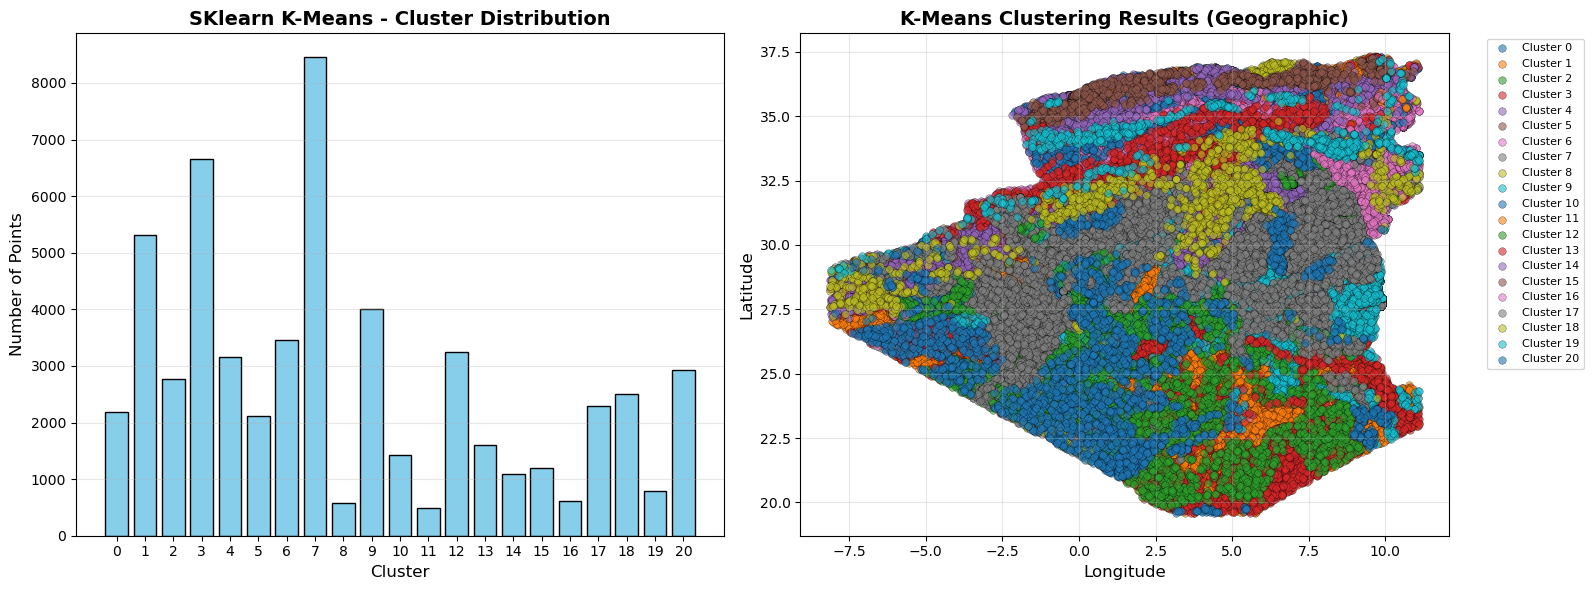

In [ ]:
"""X_array = X.to_numpy()

silhouette = silhouette_score(X_array, labels_sklearn)
davies_bouldin = davies_bouldin_score(X_array, labels_sklearn)
calinski_harabasz = calinski_harabasz_score(X_array, labels_sklearn)

print("=== SKlearn K-Means Metrics ===")
print(f"Silhouette Score: {silhouette:.4f}")
print(f"Davies-Bouldin Index: {davies_bouldin:.4f}")
print(f"Calinski-Harabasz Index: {calinski_harabasz:.4f}")

# Distribution of clusters
unique, counts = np.unique(labels_sklearn, return_counts=True)
print("\n=== Cluster Distribution ===")
for cluster, count in zip(unique, counts):
    print(f"Cluster {cluster}: {count} points ({count/len(labels_sklearn)*100:.2f}%)")

# Visualize cluster distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot
axes[0].bar(unique, counts, color='skyblue', edgecolor='black')
axes[0].set_xlabel('Cluster', fontsize=12)
axes[0].set_ylabel('Number of Points', fontsize=12)
axes[0].set_title('SKlearn K-Means - Cluster Distribution', fontsize=14, fontweight='bold')
axes[0].set_xticks(unique)
axes[0].grid(axis='y', alpha=0.3)

# Geographic visualization (lon/lat)
for cluster in unique:
    mask = labels_sklearn == cluster
    axes[1].scatter(lon_lat.loc[mask, 'lon'], lon_lat.loc[mask, 'lat'], 
                   label=f'Cluster {cluster}', 
                   s=30, alpha=0.6, edgecolors='k', linewidth=0.3)

axes[1].set_xlabel('Longitude', fontsize=12)
axes[1].set_ylabel('Latitude', fontsize=12)
axes[1].set_title('K-Means Clustering Results (Geographic)', fontsize=14, fontweight='bold')
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()"""

# Scratch Model Evaluation

=== Scratch K-Means Metrics ===
Silhouette Score: 0.2313
Davies-Bouldin Index: 1.5409
Calinski-Harabasz Index: 10205.7312

=== Cluster Distribution ===
Cluster 0: 675 points (1.19%)
Cluster 1: 18518 points (32.57%)
Cluster 2: 5316 points (9.35%)
Cluster 3: 4609 points (8.11%)
Cluster 4: 12052 points (21.19%)
Cluster 5: 8185 points (14.39%)
Cluster 6: 880 points (1.55%)
Cluster 7: 6629 points (11.66%)


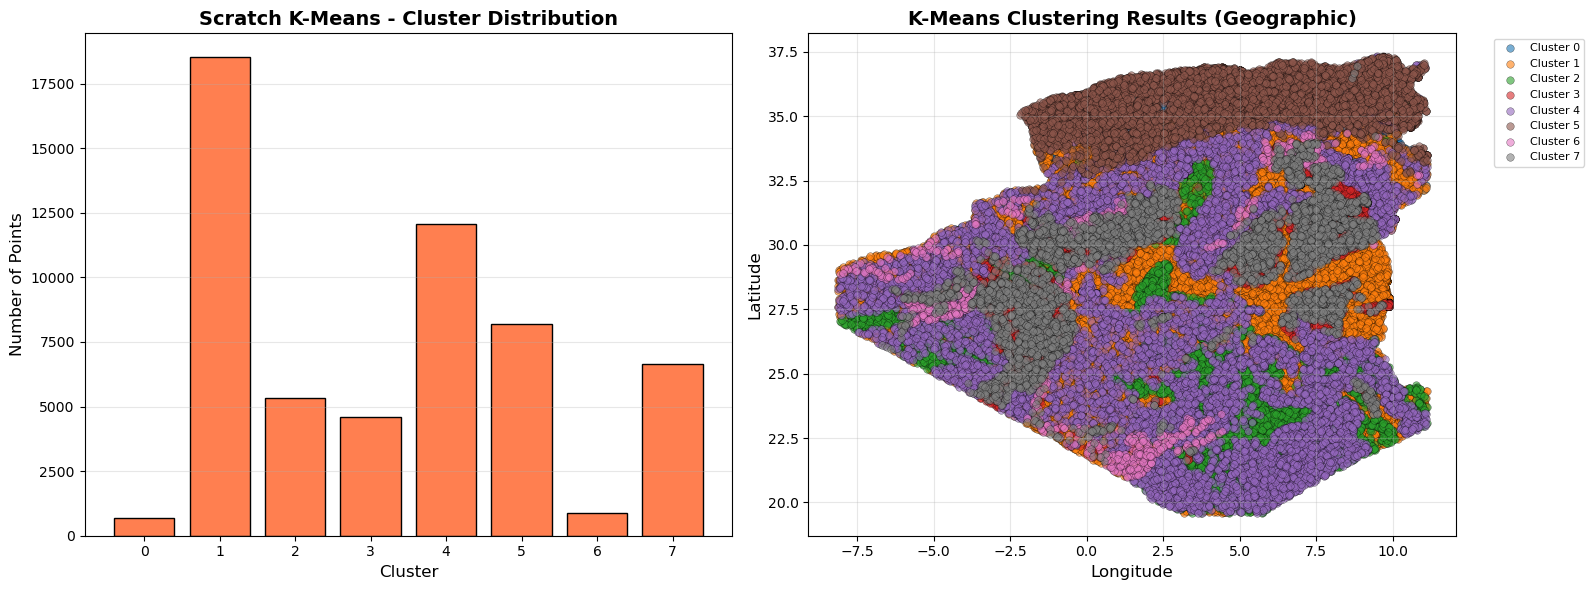

In [10]:
X_array = X.to_numpy()  # Convert to numpy array
labels_scratch = kmeans_scratch.labels_

silhouette_scratch = silhouette_score(X_array, labels_scratch)
davies_bouldin_scratch = davies_bouldin_score(X_array, labels_scratch)
calinski_harabasz_scratch = calinski_harabasz_score(X_array, labels_scratch)

print("=== Scratch K-Means Metrics ===")
print(f"Silhouette Score: {silhouette_scratch:.4f}")
print(f"Davies-Bouldin Index: {davies_bouldin_scratch:.4f}")
print(f"Calinski-Harabasz Index: {calinski_harabasz_scratch:.4f}")

# Distribution of clusters
unique_scratch, counts_scratch = np.unique(labels_scratch, return_counts=True)
print("\n=== Cluster Distribution ===")
for cluster, count in zip(unique_scratch, counts_scratch):
    print(f"Cluster {cluster}: {count} points ({count/len(labels_scratch)*100:.2f}%)")

# Visualize cluster distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot
axes[0].bar(unique_scratch, counts_scratch, color='coral', edgecolor='black')
axes[0].set_xlabel('Cluster', fontsize=12)
axes[0].set_ylabel('Number of Points', fontsize=12)
axes[0].set_title('Scratch K-Means - Cluster Distribution', fontsize=14, fontweight='bold')
axes[0].set_xticks(unique_scratch)
axes[0].grid(axis='y', alpha=0.3)

# Geographic visualization (lon/lat)
for cluster in unique_scratch:
    mask = labels_scratch == cluster
    axes[1].scatter(lon_lat.loc[mask, 'lon'], lon_lat.loc[mask, 'lat'], 
                   label=f'Cluster {cluster}', 
                   s=30, alpha=0.6, edgecolors='k', linewidth=0.3)

axes[1].set_xlabel('Longitude', fontsize=12)
axes[1].set_ylabel('Latitude', fontsize=12)
axes[1].set_title('K-Means Clustering Results (Geographic)', fontsize=14, fontweight='bold')
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Comparison

=== Comparison of Grid Search Best Model vs Scratch K-Means ===
                    Metric  SKlearn (Grid Search)        Scratch
0         Silhouette Score               0.325170       0.231320
1     Davies-Bouldin Index               1.205131       1.540925
2  Calinski-Harabasz Index           13852.912452   10205.731222
3                  Inertia          785221.682288  941476.536991


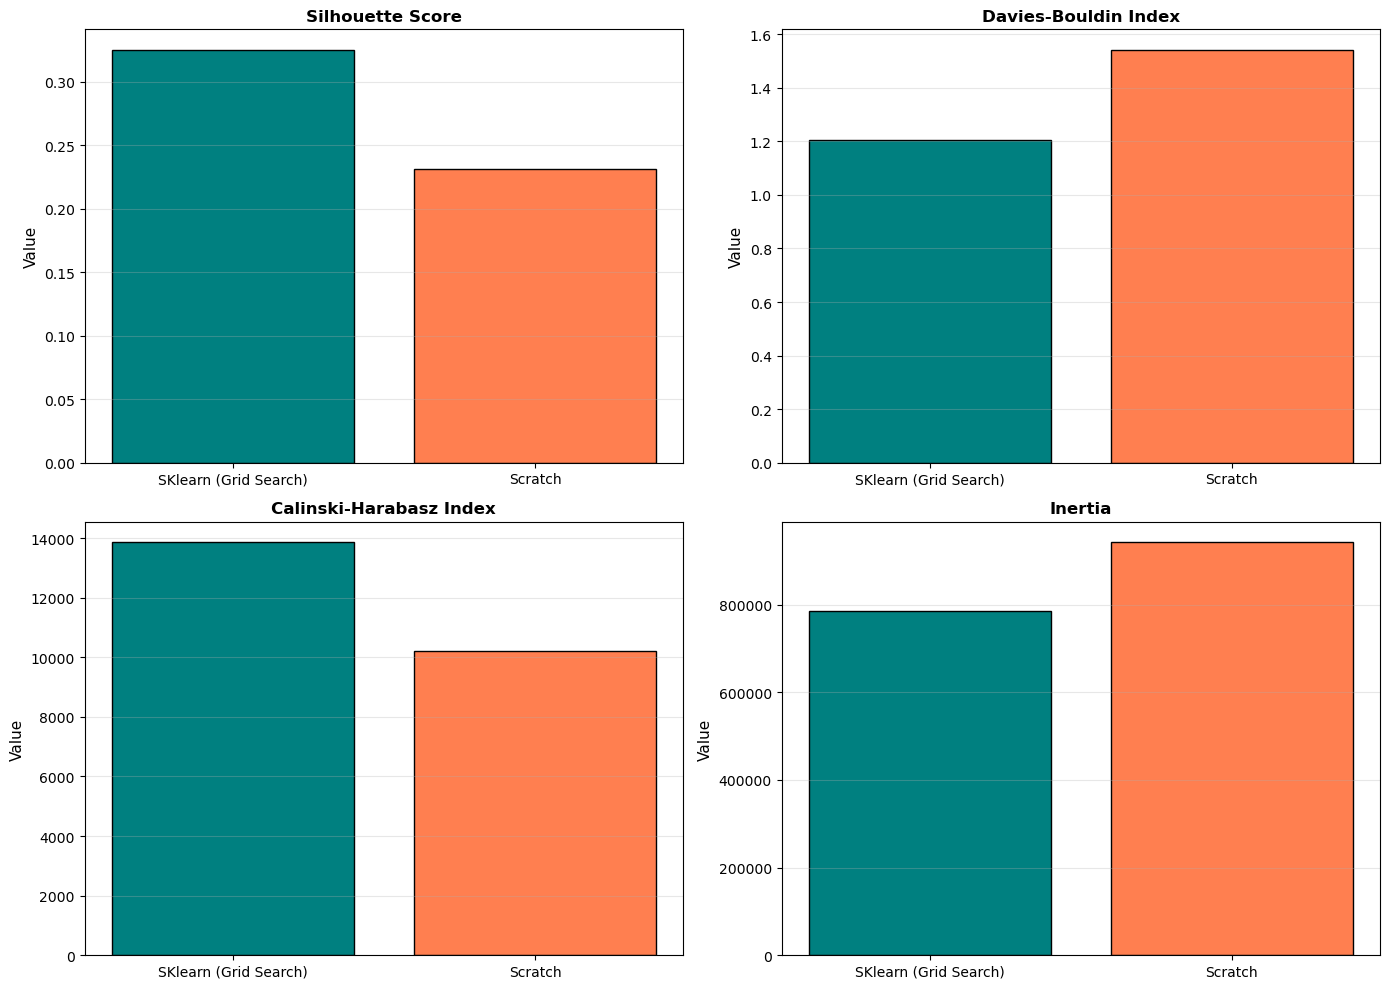

In [11]:
# Use Grid Search results for sklearn comparison
silhouette_best = silhouette_score(X, best_labels)
davies_bouldin_best = davies_bouldin_score(X, best_labels)
calinski_harabasz_best = calinski_harabasz_score(X, best_labels)

comparison_df = pd.DataFrame({
    'Metric': ['Silhouette Score', 'Davies-Bouldin Index', 'Calinski-Harabasz Index', 'Inertia'],
    'SKlearn (Grid Search)': [silhouette_best, davies_bouldin_best, calinski_harabasz_best, best_kmeans.inertia_],
    'Scratch': [silhouette_scratch, davies_bouldin_scratch, calinski_harabasz_scratch, kmeans_scratch.inertia_]
})

print("=== Comparison of Grid Search Best Model vs Scratch K-Means ===")
print(comparison_df)

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics = ['Silhouette Score', 'Davies-Bouldin Index', 'Calinski-Harabasz Index', 'Inertia']
for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    row = comparison_df[comparison_df['Metric'] == metric]
    
    ax.bar(['SKlearn (Grid Search)', 'Scratch'], [row['SKlearn (Grid Search)'].values[0], row['Scratch'].values[0]], 
           color=['teal', 'coral'], edgecolor='black')
    ax.set_title(metric, fontsize=12, fontweight='bold')
    ax.set_ylabel('Value', fontsize=11)
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()